In [6]:
import numpy as np
import pandas as pd
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import matplotlib.pyplot as plt

In [5]:
1 / np.log2(3+2)

0.43067655807339306

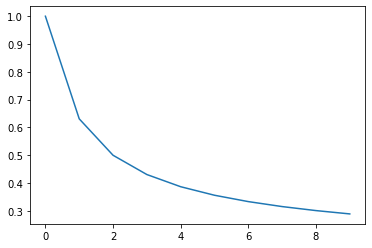

In [7]:
idxs = [i for i in range(10)]
scores = [1/np.log2(i+2) for i in idxs]

plt.plot(idxs, scores)

In [3]:
def dcg(predictions, targets):
    """Computes Discounted Cumulative Gain for a list of proposals and expected targets"""
    targets = [t.replace("\n", "").lower() for t in targets]
    score = 0
    for pred, target in zip(predictions, targets):
        if target in pred:
            idx = pred.index(target)
            score += 1 / np.log2(idx+2) 
    return score / len(predictions) * 100

In [4]:
val = pd.read_csv("val_0802.csv")

In [6]:
tokenizer = PegasusTokenizer.from_pretrained("pegasus_0802_2")
model = PegasusForConditionalGeneration.from_pretrained("pegasus_0802_2")

In [8]:
def filter_predlist(predlist):
    newlist = []
    for pred in predlist:
        if pred not in newlist:
            newlist.append(pred)
    return newlist[:10]

In [9]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]


def get_predictions(
    model, tokenizer, texts, batchsize=2, numseqs=30, device="cuda", maxlen=346
):
    model.to(device)
    model.eval()
    # texts = [f"summarize: {text}" for text in texts]
    predictions = []
    batches = chunks(texts, batchsize)
    for idx, batch in tqdm(enumerate(batches), desc="Getting predictions for DCG"):
        preds = []
        batch_encoded = tokenizer.batch_encode_plus(
            batch,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=maxlen,
        )
        batch_encoded = to_device(batch_encoded, device)
        with torch.no_grad():
            gen = model.generate(
                **batch_encoded, num_return_sequences=numseqs, num_beams=numseqs
            )
        for gen_out in gen:
            preds.append(
                tokenizer.decode(
                    gen_out.cpu().detach().numpy(),
                    skip_special_tokens=True,
                    clean_up_tokenization_spaces=False,
                )
            )
        preds = chunks(preds, numseqs)
        preds = list(map(filter_predlist, preds))
        predictions.extend(preds)
        torch.cuda.empty_cache()
    return predictions


def clean_text(text):
    text = text.replace("<br/>", " ")
    text = text.replace("<BR>", " ")
    text = text.replace("<BR/>", " ")
    text = text.replace("<br>", " ")
    text = text.replace("\xa0", " ")
    text = text.replace("•", " ")
    text = text.replace("&#39;", "'")
    text = text.replace("\n", " ")
    text = text.replace("[<>]", " ")
    clean_exprs = [
        "HEIGHT OF MODEL",
        "height of model",
        "model height",
        "MODEL HEIGHT",
        # "Contains: ",
        # "Heel height",
        # "Sole height",
        # "Height of sole",
        # "Height x Length x Width",
        # "Height x Width x Depth",
        "WARNING",
    ]
    for expr in clean_exprs:
        if expr in text:
            text = text[: text.find(expr)]
    text = text.replace(" +", " ")
    if text[-1] == " ":
        text = text[:-1]
    return text
